In [1]:
import pandas as pd
from dataloader import loadEntityData

df = loadEntityData('./data/HackerForumEntities.csv')

In [2]:
df.head()

,ID,Username,PostDate,ThreadTitle,PostContent,PostNumber,__index_level_0__,Entities
0,1,raha,2012-07-28 06:41:00,the best online solution for wordpress? ...,hi guys . i have used some plugins on m...,2.0,0,"[{'end': 252, 'entity_group': 'MISC', 'score':..."
1,2,viveksinha2016,2016-07-01 05:56:00,the best online solution for wordpress? ...,"Hi,Building a website for a business to...",3.0,1,[]
2,3,redpriest,2016-07-08 22:35:00,the best online solution for wordpress? ...,"I prefer CloudFlare, or Incapsula to do...",4.0,2,"[{'end': 26, 'entity_group': 'MISC', 'score': ..."
3,4,krishvgh,2020-02-05 06:53:00,the best online solution for wordpress? ...,There are plenty of WordPress eCommerce...,1.0,3,"[{'end': 36, 'entity_group': 'MISC', 'score': ..."
4,5,valhallen,2004-09-30 16:02:00,Question Templates - Ensure a qucik/accu...,Ok alot of people have been asking ques...,2.0,4,"[{'end': 522, 'entity_group': 'MISC', 'score':..."


In [3]:
# Unpack the list of dictionaries into a dataframe
from tqdm import tqdm
entity_df = pd.DataFrame(columns=['date', 'entity_group', 'score', 'word'])

processed_df = df

dates = []
entity_groups = []
scores = []
words = []

# Iterate over each row in the dataframe and unpack the list of dictionaries + add the date
# Track progress with tqdm
for index, row in tqdm(processed_df.iterrows(), desc='Processing rows', total=processed_df.shape[0], unit='rows'):
    date = row["PostDate"]
    entities = row["Entities"]
    for entity in entities:
        dates.append(date)
        entity_groups.append(entity['entity_group'])
        scores.append(entity['score'])
        words.append(entity['word'])
        
# Create a new dataframe from the collected lists
entity_df = pd.DataFrame({
    'date': dates,
    'entity_group': entity_groups,
    'score': scores,
    'word': words
})

entity_df["entity_group"] = entity_df["entity_group"].astype('category')
entity_df["word"] = entity_df["word"].astype('string')
entity_df["year"] = entity_df["date"].dt.year

Processing rows: 100%|██████████| 492342/492342 [00:20<00:00, 24423.85rows/s]


In [5]:
# Create an ignore list of words that don't provide much information
ignore_list = [
    "Click", # No context
    "AntiOnline", # The name of one of the forums
    "Clean", # No context
    "Asphyxia", # What does it even mean? Should be investigated further
    "Nice", # Unrealistic to have single city referenced among countries to the same degree
]
ignore_list = [word.lower() for word in ignore_list]

cleaned_entity_df = entity_df.copy()
cleaned_entity_df["word"] = entity_df["word"].str.lower().str.strip()
cleaned_entity_df = cleaned_entity_df[~cleaned_entity_df['word'].isin(ignore_list)]

# Manually aggregating different versions of USA
cleaned_entity_df["word"] = cleaned_entity_df["word"].replace("us", "usa")
cleaned_entity_df["word"] = cleaned_entity_df["word"].replace("united states", "usa")
cleaned_entity_df["word"] = cleaned_entity_df["word"].replace("america", "usa")
cleaned_entity_df["word"] = cleaned_entity_df["word"].replace("u.s.", "usa")
cleaned_entity_df["word"] = cleaned_entity_df["word"].replace("u. s.", "usa")
cleaned_entity_df["word"] = cleaned_entity_df["word"].replace("сша", "usa") # Russian for USA

# Other aggregations
cleaned_entity_df["word"] = cleaned_entity_df["word"].replace("ms", "microsoft")
cleaned_entity_df["word"] = cleaned_entity_df["word"].replace("россия", "russia")
cleaned_entity_df["word"] = cleaned_entity_df["word"].replace("россии", "russia")
cleaned_entity_df["word"] = cleaned_entity_df["word"].replace("Украина", "ukraine")

In [49]:
# Get some base statistics
print("Total entities found:", cleaned_entity_df.shape[0])
print("\nEntities by group:", cleaned_entity_df["entity_group"].value_counts())

Total entities found: 1339271

Entities by group: entity_group
MISC    998545
ORG     153189
PER     118642
LOC      68895
Name: count, dtype: int64


(-0.5, 1199.5, 799.5, -0.5)

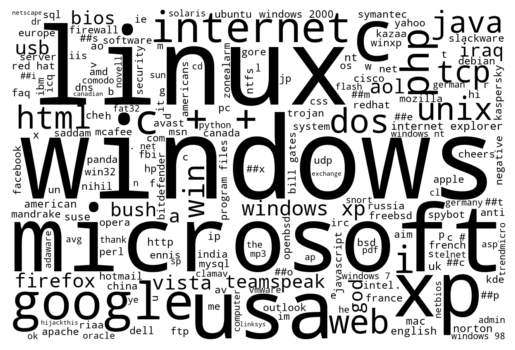

In [65]:
# Create a word cloud of the most common entities
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# Black color
def black_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "#000000"

# Group by entity_group and count the number of occurrences
word_counts_total = cleaned_entity_df['word'].value_counts()

# Create a word cloud
wordcloud = WordCloud(width=1200, height=800, background_color="white", color_func=black_color_func, collocations=False).generate_from_frequencies(word_counts_total)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')


In [16]:
import seaborn as sns

def plot_top_words_frequency(df, date_col='date', word_col='word', top_n=10, ax=None):
    # Convert the date column to datetime format
    df[date_col] = pd.to_datetime(df[date_col])

    # Extract the year from the date column
    df['year'] = df[date_col].dt.year

    # Group by year and word to count occurrences
    word_counts = df.groupby(['year', word_col]).size().reset_index(name='count')

    # Calculate total counts per year for frequency calculation
    total_counts_per_year = df.groupby('year').size().reset_index(name='total_count')

    word_counts = pd.merge(word_counts, total_counts_per_year, on='year', how='left')

    word_counts["frequency"] = word_counts["count"] / word_counts["total_count"]
    
    # Get the top n words per year
    top_words_per_year = word_counts.groupby('year').apply(lambda x: x.nlargest(top_n, 'frequency'))

    # Alternatively get the top n words overall
    top_words = word_counts.groupby(word_col)["frequency"].sum().nlargest(top_n).index
    top_words_per_year = word_counts[word_counts[word_col].isin(top_words)]

    # Set the plot size
    if ax is None:
        fig, ax = plt.subplots(figsize=(14, 7))

    # Use seaborn to plot the data
    sns.lineplot(data=top_words_per_year, x='year', y='frequency', hue=word_col, marker='o', ax=ax)

    # Set the title and labels
    ax.set_title(f'Top {top_n} Most Popular Words Over Years (Frequency)')
    ax.set_xlabel('Year')
    ax.set_ylabel('Frequency')
    ax.legend(title='Word', bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_xticks(word_counts['year'].unique())
    ax.grid(True, axis='y')
    # Save the plot in a variable
    return ax

C:\Users\Rabjho\AppData\Local\Temp\ipykernel_7104\705674785.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_words_per_year = word_counts.groupby('year').apply(lambda x: x.nlargest(top_n, 'frequency'))


<Axes: title={'center': 'Top 10 Most Popular Words Over Years (Frequency)'}, xlabel='Year', ylabel='Frequency'>

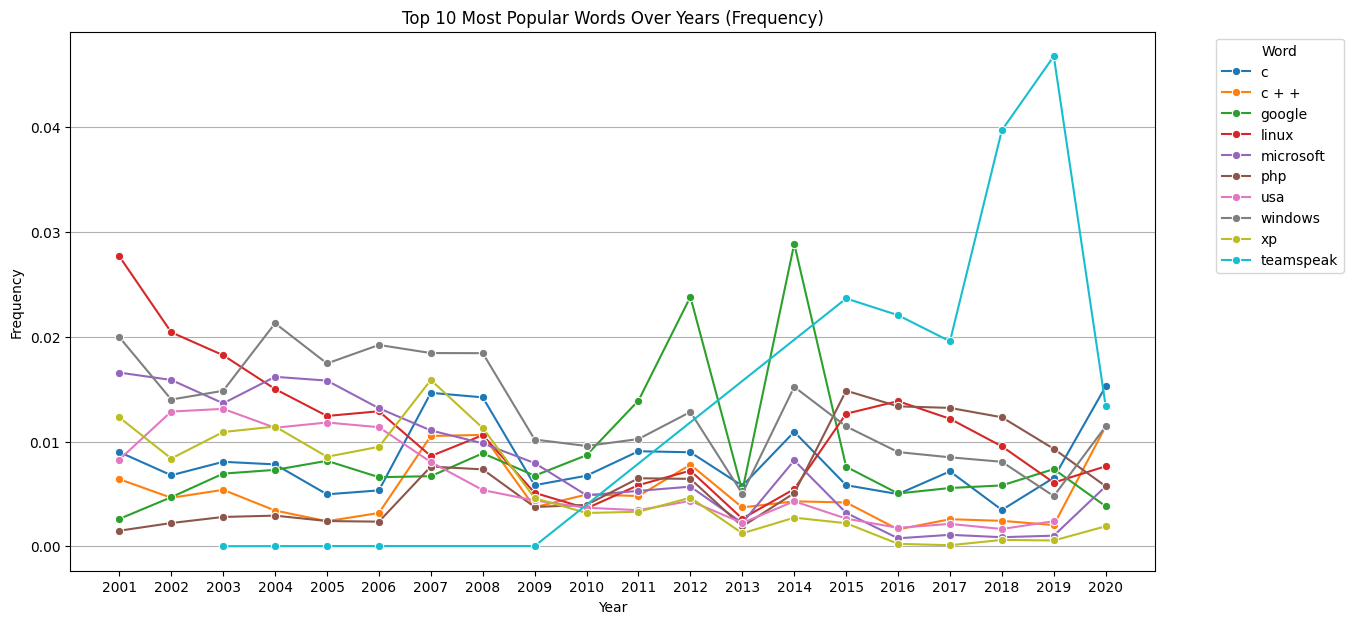

In [17]:
plot_top_words_frequency(cleaned_entity_df, top_n=10)

C:\Users\Rabjho\AppData\Local\Temp\ipykernel_7104\705674785.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[date_col] = pd.to_datetime(df[date_col])
C:\Users\Rabjho\AppData\Local\Temp\ipykernel_7104\705674785.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['year'] = df[date_col].dt.year
C:\Users\Rabjho\AppData\Local\Temp\ipykernel_7104\705674785.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the

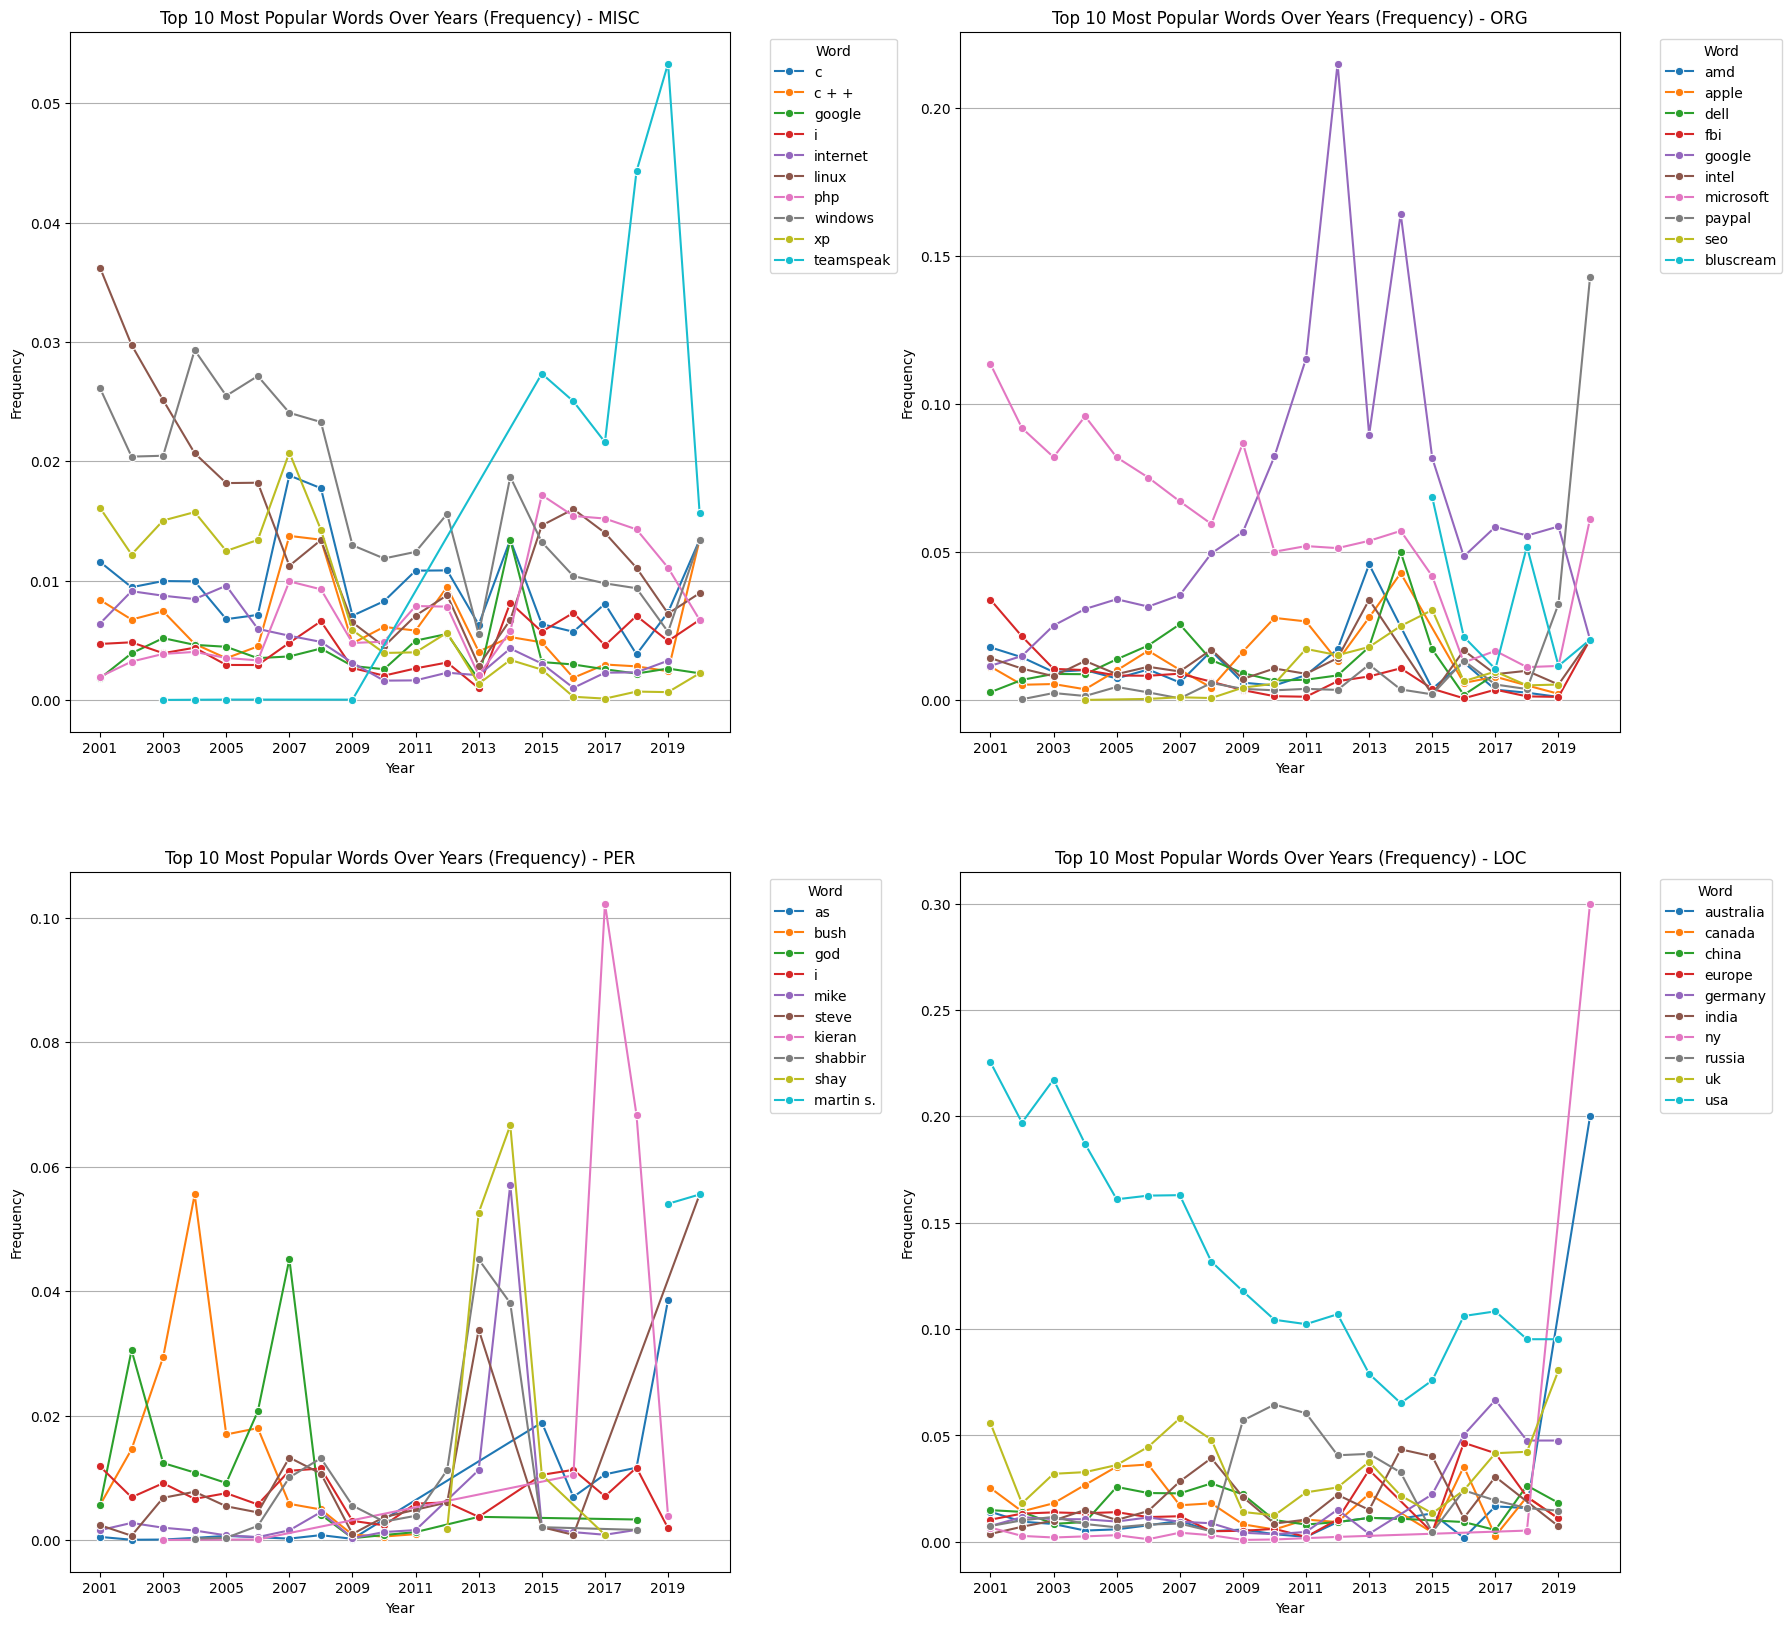

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(20, 20))

for ax, entity_group in zip(axs.flatten(), cleaned_entity_df["entity_group"].unique()):
    n = 10
    plot_top_words_frequency(cleaned_entity_df[cleaned_entity_df["entity_group"] == entity_group], top_n=n, ax=ax)

    # Set xticks to be every 3 years
    years = cleaned_entity_df['year'].unique()
    years.sort()
    ax.set_xticks(years[::2])
    
    ax.set_title(f'Top {n} Most Popular Words Over Years (Frequency) - {entity_group}')

# Adjust the spacing between subplots on the x-axis
plt.subplots_adjust(wspace=0.35)